[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/sk-classroom/asc-qbit-nn/blob/main/exercise/exercise_01.ipynb)

# Learning MNIST with a 1-bit Neural Network 


In this exercise, we will learn how to train a 1-bit neural network to classify handwritten digits.  

# Preparation

We will use the [bitnet library](https://github.com/kyegomez/BitNet), together with the standard Python stack.  


In [1]:
#! pip install bitnet
#! pip install transformers

In [2]:
from bitnet import *
import torch
from torch import optim
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Training 1-bit Neural Network 


## Task 

We will train a neural network to classify handwritten digits from the MNIST dataset.  MNIST dataset contains 70,000 28x28 grayscale images of handwritten digits. 

In [3]:
# Downloading and preprocessing the MNIST dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.view(-1, 784)),
    ]
)
train_dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)

## Train a 1-bit neural network

Our neural network should be composed of the following components: 
- We use 2 (bit-)linear layers with ReLU activation, with 128 hidden neurons.
- The input dimension should be 784 (28x28 pixels).
- The output dimension should be 10 (10 classes for 10 digits).
- No need to use softmax function for the output layer. 



In [4]:
import bitnet

# TODO: Define the model
# Two linear layers with ReLU activation, followed by a sigmoid function.
model = nn.Sequential(
    bitnet.BitLinear(784, 128),
    nn.ReLU(),
    bitnet.BitLinear(128, 10),
)

Train the model using `torch.nn.CrossEntropyLoss`

In [5]:
from tqdm import tqdm


def calculate_accuracy(output, target):
    """
    Calculate the accuracy of the model on the given output and target.
    """
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    accuracy = correct / target.size(0)
    return accuracy


def train(model, optimizer, criterion, n_epochs):
    """
    Train a model using the given optimizer and criterion.

    Parameters
    ----------
    model : torch.nn.Module
        The model to train.
    optimizer : torch.optim.Optimizer
        The optimizer to use for training.
    criterion : torch.nn.Module
        The loss function to use for training.
    n_epochs : int
        The number of epochs to train for.

    Returns
    -------
    list
        A list of the accuracies of the model at each loss value.
    """
    # Training loop
    loss_history = []
    pbar = tqdm(range(n_epochs * len(train_loader)))
    for epoch in range(n_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()

            output = model(data)
            output = output.squeeze(1)
            loss = criterion(output, target)
            loss.backward()

            optimizer.step()

            pbar.update(1)

            pbar.set_postfix({"Loss": loss.item()})
            loss_history.append(loss.item())

    return loss_history


def evaluate(model, loader):
    """
    Evaluate the model on the given loader.


    Parameters
    ----------
    model : torch.nn.Module
        The model to evaluate.
    loader : torch.utils.data.DataLoader
        The loader to use for evaluating.

    Returns
    -------
    float
        The accuracy of the model on the loader.
    """
    model.eval()
    target = []
    predicted = []
    with torch.no_grad():
        for data, _target in loader:
            output = model(data)
            output = output.squeeze(1)
            target.append(_target)
            predicted.append(output)

    output = torch.cat(predicted)
    target = torch.cat(target)
    acc = calculate_accuracy(output, target)
    return acc

In [7]:
optimizer = optim.AdamW(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
n_epochs = 5
acc_history = train(
    model=model, optimizer=optimizer, criterion=criterion, n_epochs=n_epochs
)

100%|██████████| 1175/1175 [00:32<00:00, 35.69it/s, test_acc=0.842]


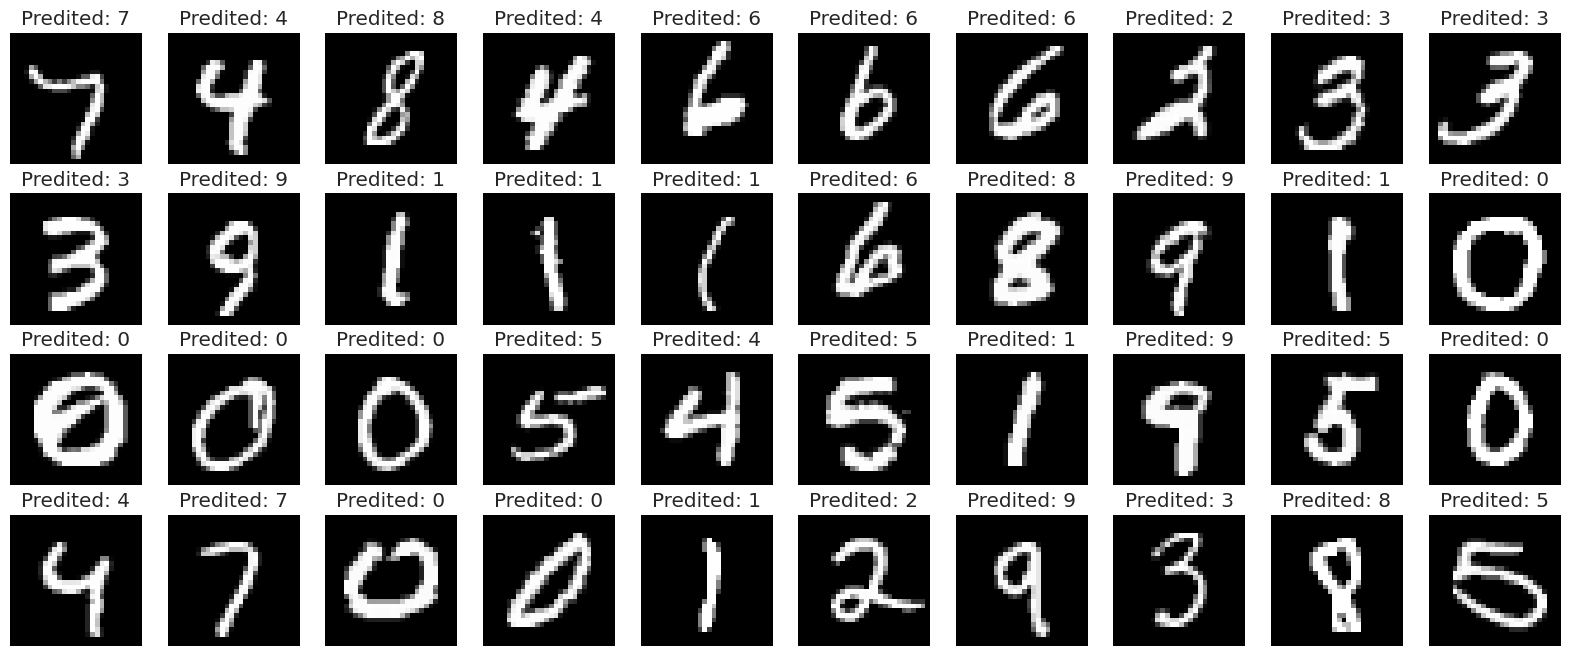

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'train_loader' is defined and is a DataLoader for the training dataset
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Sample 10 random images
idxs = np.random.choice(range(len(images)), 40, replace=False)
sampled_images = images[idxs]
sampled_labels = labels[idxs]

# Plotting
fig, axes = plt.subplots(
    4, 10, figsize=(20, 8)
)  # Adjusted for 3 additional rows, total 4 rows
for i, ax in enumerate(axes.flatten()):  # Flatten the 2D array of axes
    if i < len(sampled_images):  # Check to avoid index out of range
        pred = model(sampled_images[i].unsqueeze(0))
        pred = torch.argmax(pred, dim=2).numpy()[0, 0]
        img = (
            sampled_images[i].squeeze().reshape((28, 28))
        )  # Assuming images are 1 channel (grayscale)
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Predited: {pred}")
    ax.axis("off")
plt.show()

# Comparison with full-precision neural networks. 

- Is 1-bit neural network better than a full-precision neural network? 
- How do the training times compare? 
- How do the accuracies compare? 

In [8]:
model_fp = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
)

In [9]:
optimizer = optim.AdamW(model_fp.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
n_epochs = 5
acc_history_fp = train(
    model=model_fp,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=n_epochs,
)

100%|██████████| 1175/1175 [00:31<00:00, 37.04it/s, test_acc=0.165]  


## Q1: Is 1-bit neural network faster in training than the full-precision counterpart? 


## Q2: How do the accuracies compare? 


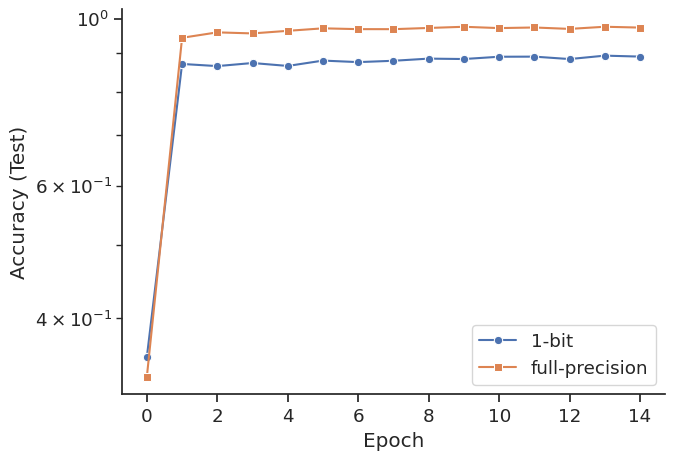

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.lineplot(acc_history, label="1-bit", marker="o")
ax = sns.lineplot(acc_history_fp, label="full-precision", marker="s")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy (Test)")
ax.set_yscale("log")
sns.despine()